In [1]:
gen = "Gen1"
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue
# https://matplotlib.org/users/dflt_style_changes.html

# Extracting observed Conc.

## Define transect

In [3]:
obs = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs.head()

,Jdays,DayMoYr,IDcal,ug.g,ug.g.SD
0,182,2016-03-30,B-182,2.864553,1.298030
1,188,2016-04-05,B-188,5.919575,2.754972
2,197,2016-04-14,B-197,4.746709,0.957630
3,201,2016-04-18,B-201,6.105674,1.029032
4,209,2016-04-26,B-209,3.838914,0.899855


# Selecting indexes

In [4]:
df = get_data(gen=gen)
counter = 0

In [17]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

['BIAS-d13C-blk',
 'NSE-CONC-tot',
 'NSE-CONC-tra',
 'NSE-CONC-blk',
 'BIAS-CONC-blk',
 'KGE-d13C-det',
 'KGE-d13C-blk',
 'BIAS-d13C-tra',
 'cZ0Z1',
 'dt_50_aged',
 'KGE-d13C_out',
 'NSE-d13C-det',
 'f_transp',
 'NSE-d13C_out',
 'MAE-LDS_out',
 'KGE-CONC-blk',
 'BIAS-d13C-det',
 'MAE-CONC_out',
 'BIAS-CONC-tot',
 'cZ',
 'KGE-CONC_out',
 'KGE-CONC-det',
 'BIAS-CONC-tra',
 'dt_50_ref',
 'MAE-d13C-tot',
 'BIAS-d13C_out',
 'MAE-CONC-blk',
 'dt_50_ab',
 'NSE-LDS_out',
 'NSE-d13C-tra',
 'NSE-d13C-blk',
 'MAE-d13C-det',
 'k_oc',
 'z3_factor',
 'BIAS-Q_out',
 'beta_runoff',
 'KGE-d13C-tot',
 'KGE-d13C-tra',
 'KGE-CONC-tot',
 'BIAS-CONC-det',
 'BIAS-CONC_out',
 'BIAS-LDS_out',
 'KGE-CONC-tra',
 'BIAS-d13C-tot',
 'NSE-CONC_out',
 'Model',
 'MAE-d13C-tra',
 'f_oc',
 'MAE-d13C-blk',
 'MAE-CONC-tra',
 'MAE-CONC-tot',
 'KGE-Q_out',
 'gammaZ',
 'NSE-d13C-tot',
 'c_adr',
 'KGE-LDS_out',
 'MAE-CONC-det',
 'NSE-CONC-det',
 'gamma01',
 'MAE-Q_out',
 'NSE-Q_out',
 'epsilon_iso',
 'MAE-d13C_out',
 'beta_mo

In [6]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-blk'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-blk'])/2.0

cst = 0.7
df['Constraint'] = df.apply(WithIsoKGE, args=(cst,), axis=1)

In [7]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7856671938254698, 0.5624784847441313)
Maximum Conc.
(0.779633598745622, 0.36008130938978367, 0.5077238884944065)
Maximum d13C
(0.9664222569512327, 0.70432567774303, 0.8186644665934912)


In [18]:
dfs = df[['Model',
          'dt_50_ref',
          'dt_50_ab',
#           'k_d',
          'epsilon_iso',
          'KGE-CONC-blk','KGE-d13C-blk',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [19]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.46)] # Try 25 with more data points
ff_c = dfs.loc[(dfs['KGE-SM'] > 0.1) & (dfs['KGE-d13C'] >  cst)]

# ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.70)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.0) & (dfs['KGE-d13C-blk'] >  cst)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

counter += 1

(9802, 39, 28)


### DT50

In [15]:
print(ff[['dt_50_ref']].mean())
print(ff[['dt_50_ref']].std())

dt_50_ref    13.986159
dtype: float64
dt_50_ref    3.841904
dtype: float64


In [16]:
print(ff_c[['dt_50_ref']].mean())
print(ff_c[['dt_50_ref']].std())

dt_50_ref    27.482066
dtype: float64
dt_50_ref    4.194091
dtype: float64


In [10]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff_c.index[(ff_c['Constraint'] == 'WC')].tolist() #[0]
print(len(nc), len(wc))

(39, 28)


## Update path for Generation

In [11]:
if counter < 2:
    path += gen + '/'

# Extracting time series

In [12]:
def get_sets_bulk(name_list):
    # Get sim conc, convert mass, ug/g -> ug
    comp = ['nor', 'val', 'sou']
    sets = []
    for i in range(len(name_list)): # Set name
        transects = []
        for tran in comp:
            # Append masses and conc.
            filename = "resM_" + tran + "CONC_real.tss"
            conc_name = tran + 'CONC'
            sim = pd.read_table(path + name_list[i] + filename, 
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', conc_name],
                                header=None)
            
            mass_name = tran + "Mass"
            sim[mass_name] = sim[conc_name] * p_b['pbAve'] * 4.0 * 10.0 * 10**3
            transects.append(sim)
            
            # Append deltas
            filename = "resM_" + tran + "d13C_real.tss"
            delta_name = tran + 'd13C'
            sim = pd.read_table(path + name_list[i] + filename,
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', delta_name],
                                header=None)
            transects.append(sim)

        # Merge all transects
        blk = reduce(lambda x, y: pd.merge(x, y, on='Jdays'), transects)

        # Bulk concentration
        conc_name = 'Conc_blk' +  name_list[i][3:]
        blk[conc_name] = (blk['norCONC']*blk['norMass'] +
                          blk['valCONC']*blk['valMass'] +
                          blk['souCONC']*blk['souMass']
                          ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])

        iso_name = 'd13C_blk' +  name_list[i][3:]
        blk[iso_name] = (blk['nord13C']*blk['norMass'] +
                         blk['vald13C']*blk['valMass'] +
                         blk['soud13C']*blk['souMass']
                        ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])
        
        
        blk = blk[['Jdays', conc_name, iso_name]]
        sets.append(blk)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

In [13]:
# sets = get_sets_bulk(wc) # Returns sets merged
# sets.tail()

# Confidence interval calc.

In [14]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [15]:
def get_stats_bulk(df, measure, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:n+1].mean(axis=1)
    df['min'] = df.iloc[:,1:n+1].min(axis=1)
    df['max'] = df.iloc[:,1:n+1].max(axis=1)
    df['sem'] = df.iloc[:,1:n+1].sem(axis=1)
    df['sd'] = df.iloc[:,1:n+1].std(axis=1)
    df['high'] = df['mean'] + 2.*df['sd']
    df['low'] = df['mean'] - 2.*df['sd']
#     df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
#     df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    if measure == "Conc":
        df['low'] = df.apply(check_negative, axis=1)
#     df['Trans'] = loc
#     df['Area'] = loc[0]
#     df['Level'] = level  # Composite or Detailed, 
    loc = "B"
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'sd', 'IDcal', 'Type']]

In [16]:
# sets_wc = get_sets_bulk(wc) 

In [17]:
sets_wc = get_sets_bulk(wc) 
sets_nc = get_sets_bulk(nc) 
time_wc = sets_wc.filter(like="Jdays")
time_nc = sets_nc.filter(like="Jdays")

conc_wc = sets_wc.filter(like='Conc')
conc_nc = sets_nc.filter(like='Conc')

conc_wc = pd.concat([time_wc, conc_wc], axis=1, join='inner')
conc_nc = pd.concat([time_nc, conc_nc], axis=1, join='inner')

In [18]:
wc_all = get_stats_bulk(conc_wc, 'Conc', 'WC')
nc_all = get_stats_bulk(conc_nc, 'Conc', 'NC')

In [19]:
wc_merged = pd.merge(wc_all, obs, how='outer', on='IDcal')
nc_merged = pd.merge(nc_all, obs, how='outer', on='IDcal')

In [20]:
# wc_merged[20:25]
wc_merged.tail()

,Jdays_x,mean,high,low,max,min,sd,IDcal,Type,Jdays_y,DayMoYr,ug.g,ug.g.SD
116,282,1.967463,2.732963,1.201962,2.653262,1.163263,0.382750,B-282,WC,NaN,NaN,NaN,NaN
117,283,1.927449,2.684598,1.170300,2.598626,1.129942,0.378574,B-283,WC,NaN,NaN,NaN,NaN
118,284,1.889446,2.639580,1.139312,2.548244,1.097593,0.375067,B-284,WC,NaN,NaN,NaN,NaN
119,285,1.851027,2.599556,1.102499,2.512422,1.064235,0.374264,B-285,WC,NaN,NaN,NaN,NaN
120,286,1.814430,2.557530,1.071331,2.473016,1.033834,0.371550,B-286,WC,286.0,2016-07-12,1.301117,0.169956


In [21]:
# nc_merged.head()
# sets_all = pd.concat([nc_merged, wc_merged])

In [22]:
# ff.tail() ff_c.tail()
fix_nc = ff.loc[(ff['Model']=='fix')]
var_nc = ff.loc[(ff['Model']=='var')]
fix_wc = ff_c.loc[(ff_c['Model']=='fix')]
var_wc = ff_c.loc[(ff_c['Model']=='var')]

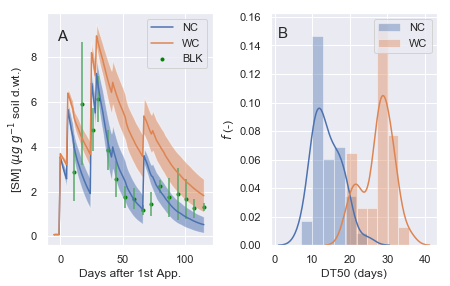

In [55]:
# sns.set(rc={'figure.figsize':(11.7, 8.27)})
# ES&T max width, 1 column = 3.25in, 2-col = 7in 
sns.set_context("paper")
sns.set(rc={'figure.figsize':(7.0, 4.27)}) # Width, height, inches

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)

time = np.array(nc_merged['Jdays_x']-171)
obs_conc = np.array(nc_merged['ug.g'])
err = np.array(nc_merged['ug.g.SD'])
nc_mean = np.array(nc_merged['mean'])
nc_high = np.array(nc_merged['high'])
nc_low = np.array(nc_merged['low'])

wc_mean = np.array(wc_merged['mean'])
wc_high = np.array(wc_merged['high'])
wc_low = np.array(wc_merged['low'])

# ax1.annotate('A', fontsize=15,
#             xy=(50, 225), xycoords='figure pixels')
# ax2.annotate('B', fontsize=15,
#             xy=(275, 225), xycoords='figure pixels')
ax1.annotate('A', fontsize=15,
            xy=(-3, 8.7), xycoords='data')
ax2.annotate('B', fontsize=15,
            xy=(1, 0.145), xycoords='data')


# NC
ax1.plot(time, nc_mean, label='NC') # c= "red", marker='.', linestyle=':'
ax1.legend(loc="upper right")
ax1.fill_between(time, nc_high, nc_low, alpha=0.5)
# WC
ax1.plot(time, wc_mean, label='WC') # c= "red", marker='.', linestyle=':'
ax1.legend(loc="upper right")
ax1.fill_between(time, wc_high, wc_low, alpha=0.5)
# Obs
ax1.errorbar(time, obs_conc, err)
ax1.scatter(time, obs_conc, c= "green", marker='.', label="BLK")
ax1.legend(loc="upper right")
ax1.set_ylabel("[SM] ($\mu g$ $g^{-1}$ soil d.wt.)")
ax1.set_xlabel("Days after 1st App.")

sns.distplot( ff["dt_50_ref"] , color="C0", label="NC", ax=ax2)
# sns.distplot( var_nc["dt_50_ref"] , color="red", label="Var - NC", ax=ax2)
sns.distplot( ff_c["dt_50_ref"] , color="C1", label="WC", ax=ax2)
# sns.distplot( var_wc["dt_50_ref"] , color="teal", label="Var - WC", ax=ax2)
ax2.set_xlabel("DT50 (days)")
ax2.set_ylabel("$f$ (-)")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.35, hspace=None)
plt.legend()

fig.savefig("Fig1_FitNC.pdf")
# sns.pointplot(x="Jdays_x", y="ug.g", data=sets_all.loc[sets_all['Type']=="WC"], join=False, ax=ax1)

In [24]:
200-171

29

https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/